# Problems
In Topfarm the problem is the collection/container of components and drivers. Optimizing a problem is executing a workflow - finding the best feasible solution under a series of constraints using a specific driver, and initial conditions. To the problem is also attached a plotting routine so one can follow the optimization path as well as a recorder so that intermediate variable values are accessible after the optimization is finished. The Topfarm Problem inherits its fundamental nature from the OpenMDAO problem, and is being adapted so it can connect the given workflow with the driver. For example if the user specifies a boundary constraint and this is not supported by the driver, the Problem is equipped with a penalty component that will deter the driver giving unfeasible solutions. Or if your workflow does not have gradients for all components and a gradient based driver is specified, finite differencing is applied to obtain the gradients. 

[Try this yourself](https://colab.research.google.com/github/DTUWindEnergy/TopFarm2/blob/master/docs/notebooks/problems.ipynb) (requires google account)


In [0]:
# Install TopFarm if needed
import importlib
if not importlib.util.find_spec("topfarm"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git

**Jump to example in this notebook**:

* [Turbine location optimization](#Turbine-location-optimization)

Make sure you first run the code below in order to set up and initialize needed variables.

**First we install topfarm and import supporting libraries in Python numpy and matplotlib**

In [2]:
# non-updating, inline plots
#%matplotlib inline
# ...or updating plots in new window
# %matplotlib qt

In [3]:
import numpy as np
import matplotlib.pyplot as plt 

**Next we import and initialize several functions and classes from Topfarm to set up the problem including:**
* **TopFarmProblem - overall topfarm problem class to which the objectives, design variables, and constraints are added**
* **EasyScipyOptimizeDriver - a subclass of ScipyOptimizeDriver which is configured for the given workflow**
* **get_iea37_initial, get_iea37_constraints, get_iea37_cost - functions to get the initial layout, the constraints and the cost function for the IEA task 37 benchmark example**
* **NoPlot, XYPlotComp - plotting components to visualize the results**

In [4]:
from topfarm import TopFarmProblem
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm.examples.iea37 import get_iea37_initial, get_iea37_constraints, get_iea37_cost
from topfarm.plotting import NoPlot, XYPlotComp

## Turbine location optimization

This example optimizes the locations of the 9-turbine benchmark wind farm from IEA Task 37 using the provided initial locations and the `EasyScipyOptimizeDriver`. Details on the benchmark can be found in the following reference:  

* Baker et al. (2019) "Best Practices for Wake Model and Optimization Algorithm Selection in Wind Farm Layout Optimization". AIAA 2019.

In [14]:
from py_wake.deficit_models.gaussian import IEA37SimpleBastankhahGaussian
from py_wake.examples.data.iea37 import IEA37_WindTurbines, IEA37Site
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent
def get_iea37_cost(n_wt=9, n_wd=16):
    """Cost component that wraps the IEA 37 AEP calculator"""
    wd = np.linspace(0., 360., n_wd, endpoint=False)
    site = IEA37Site(n_wt)
    wind_turbines = IEA37_WindTurbines()
    wake_model = IEA37SimpleBastankhahGaussian(site, wind_turbines)    
    return PyWakeAEPCostModelComponent(wake_model, n_wt, wd=wd)

In [15]:
def optimize_iea37_locs(n_wt, n_wd, driver, state=None):
    """
    Parameters
    ----------
    - n_wt: int
        Number of wind turbines

    - n_wd: int
        Number of wind directions to consider for the AEP
        
    - driver: TopfarmDriver instance
        The optimization algorithm to use
        
    - state: dict(x=[], y=[]) [default=None]
        State to start from the optimization
    
    Returns
    -------
    - state: The state after the optimization

    """
    
    initial = get_iea37_initial(n_wt)
    design_vars = dict(zip('xy', (initial[:, :2]).T))
    
    tf = TopFarmProblem(
            design_vars,
            get_iea37_cost(n_wt, n_wd=n_wd),
            constraints=get_iea37_constraints(n_wt),
            driver=driver,
            plot_comp=XYPlotComp())
    
    if not state:
        _, state = tf.evaluate()
        
    _, state, _ = tf.optimize(state)
    return state, 

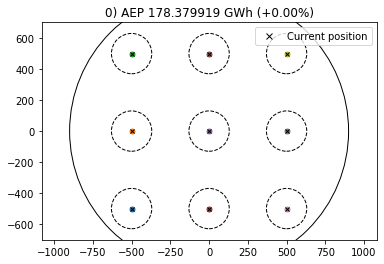

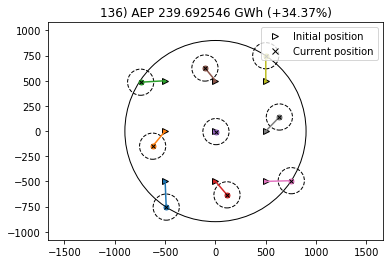

In [16]:
state = optimize_iea37_locs(9, 16, EasyScipyOptimizeDriver(disp=False))

The final optimized output is much lower than the value reported in Baker et al. (2019), which is 257.790 GWh. Moreover, the layout does not match the figures given in Appendix A in the same reference. This is due to the fact that the SLSQP optimizer was attracted to a local minimum. To find the global optimum, more advanced optimization procedures should be used. This benchmark is discussed in more detail in the validation report linked in TOPFARM's documentation.

In [17]:
state

({'x': array([-489.46501777, -624.2844273 , -743.31444811,  114.47180363,
            4.79839641, -104.62314952,  753.13964641,  634.76336704,
          499.54696312]),
  'y': array([-755.26418982, -150.13501614,  485.63206009, -633.34897407,
           -5.11108932,  626.54927966, -492.72778799,  139.86686411,
          748.63397713])},)